In [1]:
import os, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix, roc_curve)
import matplotlib.pyplot as plt

from data_processor import load_features_and_split3, class_weight_hint  # your helper

# Repro
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data
X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
    "orbit_results.csv", test_size=0.20, val_size=0.10, random_state=SEED, stratify=True
)
feat_names = list(X_train.columns)

# Scale features for MLP
scaler = StandardScaler().fit(X_train.values)
Xtr = scaler.transform(X_train.values)
Xva = scaler.transform(X_val.values)
Xte = scaler.transform(X_test.values)

ytr = y_train.values.astype(np.float32)
yva = y_val.values.astype(np.float32)
yte = y_test.values.astype(np.float32)

# Dataloaders
BATCH = 256
train_ds = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).float())
val_ds   = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).float())
test_ds  = TensorDataset(torch.from_numpy(Xte).float(), torch.from_numpy(yte).float())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# Class imbalance hint -> pos_weight for BCEWithLogits
spw = class_weight_hint(y_train)  # neg/pos
pos_weight = torch.tensor([spw], device=device, dtype=torch.float32)
print("scale_pos_weight ~", spw)


Using device: cuda
scale_pos_weight ~ 7.433734939759036


In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden=(64, 64), dropout=0.1):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # logits


In [3]:
in_dim = Xtr.shape[1]
model = MLP(in_dim, hidden=(128, 64), dropout=0.1).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # logloss with class weight
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS = 200
PATIENCE = 25

def run_epoch(loader, train: bool):
    model.train(mode=train)
    total_loss, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            bs = yb.size(0)
            total_loss += loss.item() * bs
            n += bs
    return total_loss / max(n, 1)

history = {"train_logloss": [], "val_logloss": []}
best_val = float("inf")
best_epoch = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train_loader, True)
    va_loss = run_epoch(val_loader, False)
    history["train_logloss"].append(tr_loss)
    history["val_logloss"].append(va_loss)

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # early stopping
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best={best_epoch}, val_logloss={best_val:.4f})")
        break

# Load best
if best_state is not None:
    model.load_state_dict(best_state)
print(f"Best epoch: {best_epoch}, best val logloss: {best_val:.4f}")


Early stopping at epoch 135 (best=110, val_logloss=0.5948)
Best epoch: 110, best val logloss: 0.5948


Test ROC AUC: 0.9527
Test PR  AUC: 0.7832

Classification report:
               precision    recall  f1-score   support

         0.0      0.987     0.892     0.937       176
         1.0      0.537     0.917     0.677        24

    accuracy                          0.895       200
   macro avg      0.762     0.904     0.807       200
weighted avg      0.933     0.895     0.906       200



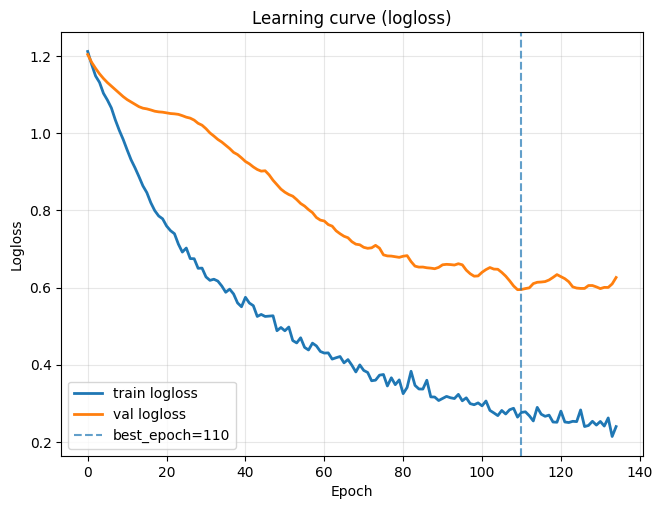

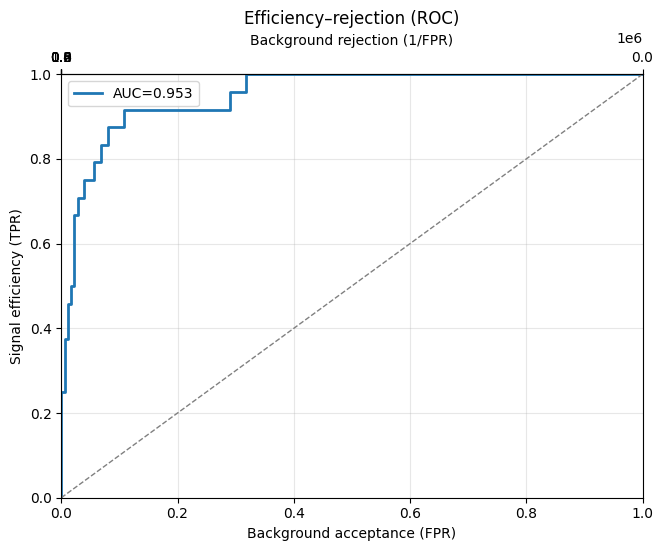

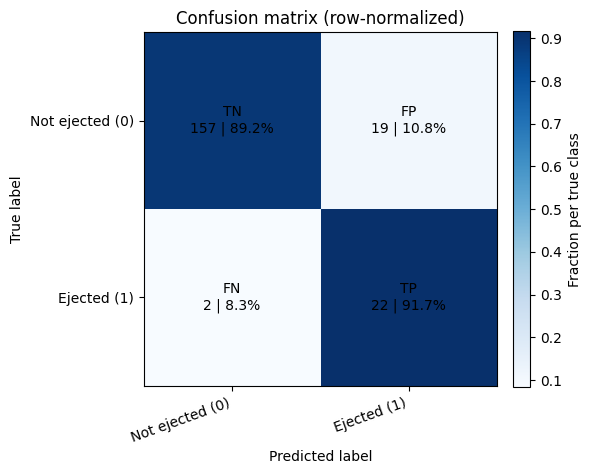

In [4]:
# Predict probabilities on test
model.eval()
proba_list, y_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        proba = torch.sigmoid(logits).cpu().numpy()
        proba_list.append(proba)
        y_list.append(yb.numpy())
proba = np.concatenate(proba_list)
y_true = np.concatenate(y_list)
pred = (proba >= 0.5).astype(int)

# Scalars
print(f"Test ROC AUC: {roc_auc_score(y_true, proba):.4f}")
print(f"Test PR  AUC: {average_precision_score(y_true, proba):.4f}")
print("\nClassification report:\n", classification_report(y_true, pred, digits=3))

# A) Learning curve (logloss)
plt.figure(figsize=(7.5,5.5))
plt.plot(history["train_logloss"], label="train logloss", lw=2)
plt.plot(history["val_logloss"],   label="val logloss",   lw=2)
plt.axvline(best_epoch, ls="--", alpha=0.7, label=f"best_epoch={best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.title("Learning curve (logloss)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# B) ROC with background rejection top axis
fpr, tpr, _ = roc_curve(y_true, proba)
fig, ax = plt.subplots(figsize=(7.5,5.5))
ax.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(y_true, proba):.3f}")
ax.plot([0,1], [0,1], ls="--", lw=1, color="gray")
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("Background acceptance (FPR)")
ax.set_ylabel("Signal efficiency (TPR)")
ax.set_title("Efficiency–rejection (ROC)")
def fwd(f): f = np.clip(np.array(f), 1e-6, 1.0); return 1.0/f
def inv(r): r = np.clip(np.array(r), 1.0, 1e6);  return 1.0/r
secax = ax.secondary_xaxis('top', functions=(fwd, inv))
secax.set_xlabel("Background rejection (1/FPR)")
ax.grid(True, alpha=0.3); ax.legend(); plt.show()

# C) Pretty confusion matrix
cm  = confusion_matrix(y_true, pred)
cmn = cm / cm.sum(axis=1, keepdims=True)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
classes = ["Not ejected (0)", "Ejected (1)"]

fig, ax = plt.subplots(figsize=(6,5.5))
im = ax.imshow(cmn, cmap="Blues")
ax.set_title("Confusion matrix (row-normalized)")
ax.set_xticks([0,1], labels=classes, rotation=20, ha="right")
ax.set_yticks([0,1], labels=classes)
for (i, j), v in np.ndenumerate(cmn):
    ax.text(j, i, f"{labels[i,j]}\n{cm[i,j]} | {v*100:.1f}%", ha="center", va="center", fontsize=10)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Fraction per true class")
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
plt.tight_layout(); plt.show()


In [5]:
os.makedirs("artifacts", exist_ok=True)

# Save model
torch.save(model.state_dict(), "artifacts/mlp_state.pt")

# Save scaler
import joblib
joblib.dump(scaler, "artifacts/mlp_scaler.joblib")

# Save metadata for consistent reload
mlp_meta = {
    "framework": "pytorch",
    "model_file": "mlp_state.pt",
    "scaler_file": "mlp_scaler.joblib",
    "feature_names": feat_names,
    "hidden": [128, 64],
    "dropout": 0.1,
    "best_epoch": int(best_epoch),
    "threshold": 0.5,
    "seed": SEED,
    "pos_weight": float(spw),
}
with open("artifacts/mlp_meta.json", "w") as f:
    json.dump(mlp_meta, f, indent=2)

print("Saved artifacts/mlp_state.pt, mlp_scaler.joblib, mlp_meta.json")


Saved artifacts/mlp_state.pt, mlp_scaler.joblib, mlp_meta.json


'\ndef build_mlp_from_meta(meta: dict, in_dim: int) -> nn.Module:\n    return MLP(in_dim, hidden=tuple(meta.get("hidden", [128,64])),\n               dropout=float(meta.get("dropout", 0.1)))\n\ndef load_mlp_and_predict_proba(X: pd.DataFrame, model_dir="artifacts", device_override=None) -> np.ndarray:\n    dev = device_override or ("cuda" if torch.cuda.is_available() else "cpu")\n    dev = torch.device(dev)\n\n    with open(f"{model_dir}/mlp_meta.json") as f:\n        meta = json.load(f)\n    scaler = joblib.load(f"{model_dir}/{meta[\'scaler_file\']}")\n\n    # ensure feature order\n    X_use = X[meta["feature_names"]].values\n    X_use = scaler.transform(X_use)\n\n    model = build_mlp_from_meta(meta, in_dim=X_use.shape[1])\n    model.load_state_dict(torch.load(f"{model_dir}/{meta[\'model_file\']}", map_location=dev))\n    model.to(dev).eval()\n\n    proba_list = []\n    BS = 512\n    with torch.no_grad():\n        for i in range(0, len(X_use), BS):\n            xb = torch.from_numpy(X